In [1]:
import xml.etree.ElementTree as ET
import pandas as pd

# Load the XML file
file_path = "export.xml"  # Replace with your file path
tree = ET.parse(file_path)
root = tree.getroot()

# Initialize lists to store data for each category
calories_data = []
step_count_data = []
body_mass_data = []

# Extract relevant information
for record in root.findall('./Record'):
    record_type = record.get('type')
    record_date = record.get('startDate')
    record_value = record.get('value')
    record_source = record.get('sourceName')
    
    # Extract calories burned data
    if record_type in ["HKQuantityTypeIdentifierBasalEnergyBurned", "HKQuantityTypeIdentifierActiveEnergyBurned"]:
        calories_data.append({
            "Type": "Basal" if record_type == "HKQuantityTypeIdentifierBasalEnergyBurned" else "Active",
            "Date": record_date,
            "Value": float(record_value),
            "Source": record_source
        })
    
    # Extract step count data
    elif record_type == "HKQuantityTypeIdentifierStepCount":
        step_count_data.append({
            "Date": record_date,
            "Value": float(record_value),
            "Source": record_source
        })
    
    # Extract body mass data
    elif record_type == "HKQuantityTypeIdentifierBodyMass":
        body_mass_data.append({
            "Date": record_date,
            "Value": float(record_value),
            "Source": record_source
        })

# Convert each list to a DataFrame
calories_burned_df = pd.DataFrame(calories_data)
step_count_df = pd.DataFrame(step_count_data)
body_mass_df = pd.DataFrame(body_mass_data)

# Display the first few rows of each DataFrame
print("Calories Burned Data:")
print(calories_burned_df.head())

print("\nStep Count Data:")
print(step_count_df.head())

print("\nBody Mass Data:")
print(body_mass_df.head())

# Convert dates to datetime format for all DataFrames
calories_burned_df["Date"] = pd.to_datetime(calories_burned_df["Date"])
step_count_df["Date"] = pd.to_datetime(step_count_df["Date"])
body_mass_df["Date"] = pd.to_datetime(body_mass_df["Date"])

# Create a combined DataFrame for correlation analysis
# Aggregate daily values for calories burned
daily_calories = calories_burned_df.groupby([calories_burned_df["Date"].dt.date, "Type"])["Value"].sum().unstack(fill_value=0)
daily_calories = daily_calories.reset_index()
daily_calories.rename(columns={"index": "Date"}, inplace=True)

# Aggregate daily step count
daily_steps = step_count_df.groupby(step_count_df["Date"].dt.date)["Value"].sum().reset_index()
daily_steps.columns = ["Date", "StepCount"]

# Aggregate body mass (take the last entry of the day as a representative value)
daily_body_mass = body_mass_df.groupby(body_mass_df["Date"].dt.date)["Value"].last().reset_index()
daily_body_mass.columns = ["Date", "BodyMass"]

# Merge all DataFrames for correlation analysis
combined_df = pd.merge(daily_calories, daily_steps, on="Date", how="outer")
combined_df = pd.merge(combined_df, daily_body_mass, on="Date", how="outer")

# Display the combined DataFrame
print("\nCombined DataFrame for Correlation Analysis:")
print(combined_df.head())

Calories Burned Data:
    Type                       Date   Value               Source
0  Basal  2021-12-20 12:38:20 +0300   6.314  Faruk’s Apple Watch
1  Basal  2021-12-20 12:45:16 +0300  74.215  Faruk’s Apple Watch
2  Basal  2021-12-20 13:44:06 +0300  20.626  Faruk’s Apple Watch
3  Basal  2021-12-20 13:59:00 +0300  19.652  Faruk’s Apple Watch
4  Basal  2021-12-20 14:13:58 +0300  19.596  Faruk’s Apple Watch

Step Count Data:
                        Date  Value          Source
0  2021-08-02 16:38:48 +0300  320.0  Faruk’s iPhone
1  2021-08-02 16:48:59 +0300  141.0  Faruk’s iPhone
2  2021-08-02 17:27:28 +0300  182.0  Faruk’s iPhone
3  2021-08-02 17:37:30 +0300  323.0  Faruk’s iPhone
4  2021-08-02 17:52:38 +0300  295.0  Faruk’s iPhone

Body Mass Data:
                        Date  Value  Source
0  2021-09-22 10:55:44 +0300   77.5  Health
1  2021-12-19 21:51:00 +0300   80.0  Health
2  2022-04-16 10:07:00 +0300   78.6  Health
3  2022-04-22 21:29:00 +0300   77.7  Health
4  2022-09-21 08:11:2

Step Count Statistics:
count    47381.000000
mean       238.867415
std        259.013067
min          1.000000
25%         36.000000
50%        131.000000
75%        374.000000
max       1366.000000
Name: Value, dtype: float64


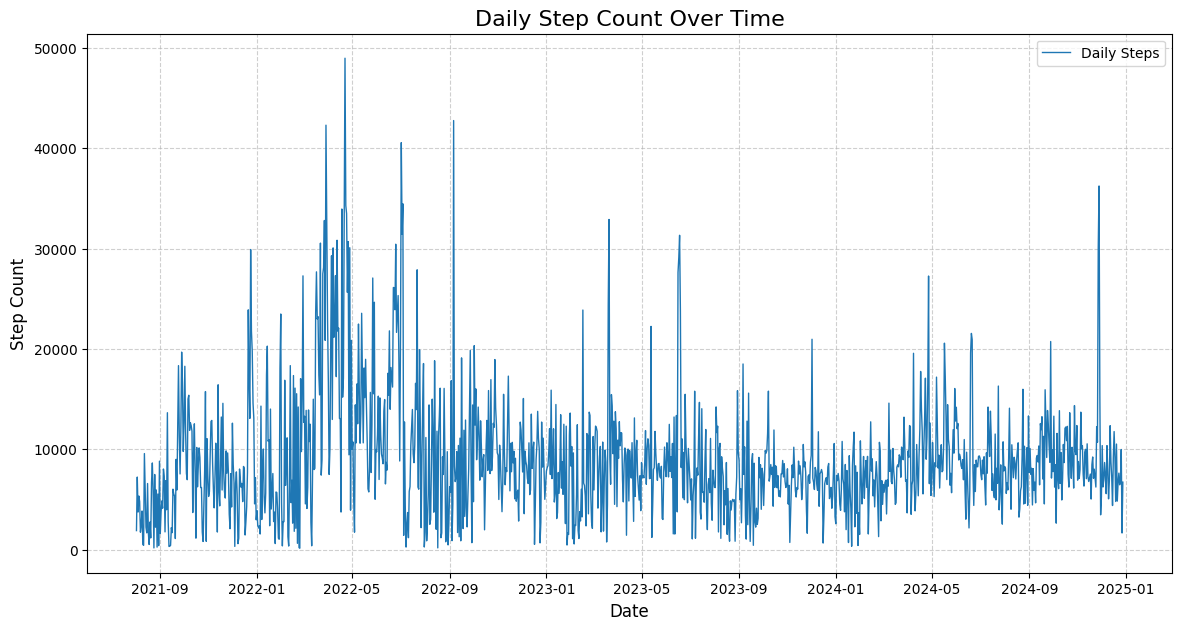

In [2]:
import matplotlib.pyplot as plt

# Descriptive statistics for step count
step_stats = step_count_df["Value"].describe()
print("Step Count Statistics:")
print(step_stats)

# Aggregate daily step counts for visualization
daily_steps = step_count_df.groupby(step_count_df["Date"].dt.date)["Value"].sum().reset_index()
daily_steps.columns = ["Date", "TotalSteps"]

# Plot daily step count
plt.figure(figsize=(14, 7))
plt.plot(daily_steps["Date"], daily_steps["TotalSteps"], label="Daily Steps", linewidth=1)
plt.title("Daily Step Count Over Time", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Step Count", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()



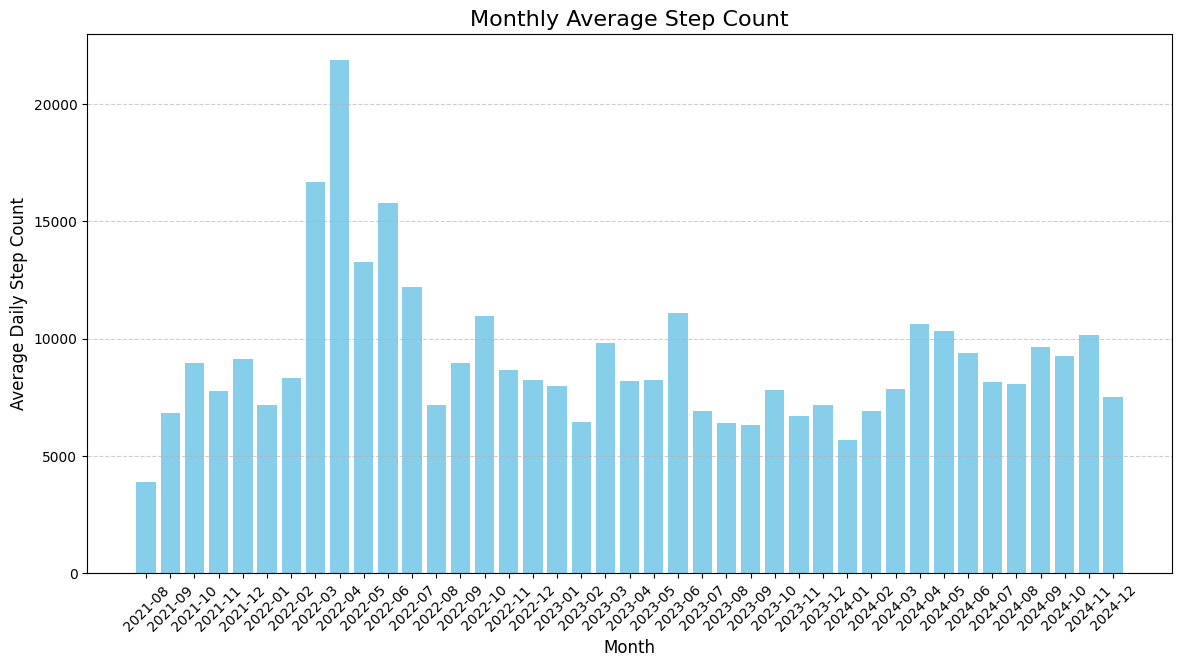

Monthly Average Step Counts:
      Month    TotalSteps
0   2021-08   3876.800000
1   2021-09   6811.766667
2   2021-10   8949.322581
3   2021-11   7763.033333
4   2021-12   9131.806452
5   2022-01   7159.451613
6   2022-02   8307.107143
7   2022-03  16670.129032
8   2022-04  21900.400000
9   2022-05  13248.870968
10  2022-06  15800.533333
11  2022-07  12210.870968
12  2022-08   7166.161290
13  2022-09   8967.400000
14  2022-10  10955.774194
15  2022-11   8645.200000
16  2022-12   8249.483871
17  2023-01   7965.741935
18  2023-02   6439.071429
19  2023-03   9824.483871
20  2023-04   8194.566667
21  2023-05   8230.935484
22  2023-06  11092.700000
23  2023-07   6898.741935
24  2023-08   6404.225806
25  2023-09   6331.333333
26  2023-10   7824.193548
27  2023-11   6706.566667
28  2023-12   7147.548387
29  2024-01   5682.354839
30  2024-02   6902.137931
31  2024-03   7830.032258
32  2024-04  10632.633333
33  2024-05  10320.161290
34  2024-06   9393.733333
35  2024-07   8156.064516
36  2024-

In [3]:
# Identify trends or patterns
# Group by month and compute average daily steps
monthly_steps = daily_steps.copy()
monthly_steps["Month"] = pd.to_datetime(monthly_steps["Date"]).dt.to_period("M")
monthly_avg_steps = monthly_steps.groupby("Month")["TotalSteps"].mean().reset_index()

# Plot monthly average step counts
plt.figure(figsize=(14, 7))
plt.bar(monthly_avg_steps["Month"].astype(str), monthly_avg_steps["TotalSteps"], color="skyblue")
plt.title("Monthly Average Step Count", fontsize=16)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Average Daily Step Count", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

# Print monthly average step count
print("Monthly Average Step Counts:")
print(monthly_avg_steps)

Activity Level Distribution:
ActivityLevel
Very Active          401
Moderately Active    290
Lightly Active       281
Sedentary            273
Name: count, dtype: int64


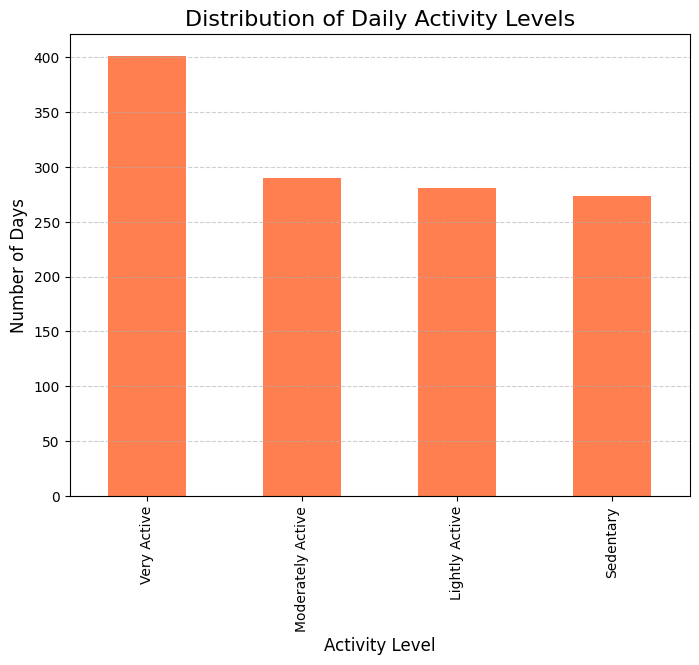

In [4]:
def categorize_steps(steps):
    if steps < 5000:
        return "Sedentary"
    elif 5000 <= steps < 7500:
        return "Lightly Active"
    elif 7500 <= steps < 10000:
        return "Moderately Active"
    else:
        return "Very Active"

daily_steps["ActivityLevel"] = daily_steps["TotalSteps"].apply(categorize_steps)

# Count days in each activity level
activity_levels = daily_steps["ActivityLevel"].value_counts()
print("Activity Level Distribution:")
print(activity_levels)

# Visualize activity level distribution
plt.figure(figsize=(8, 6))
activity_levels.plot(kind="bar", color="coral")
plt.title("Distribution of Daily Activity Levels", fontsize=16)
plt.xlabel("Activity Level", fontsize=12)
plt.ylabel("Number of Days", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

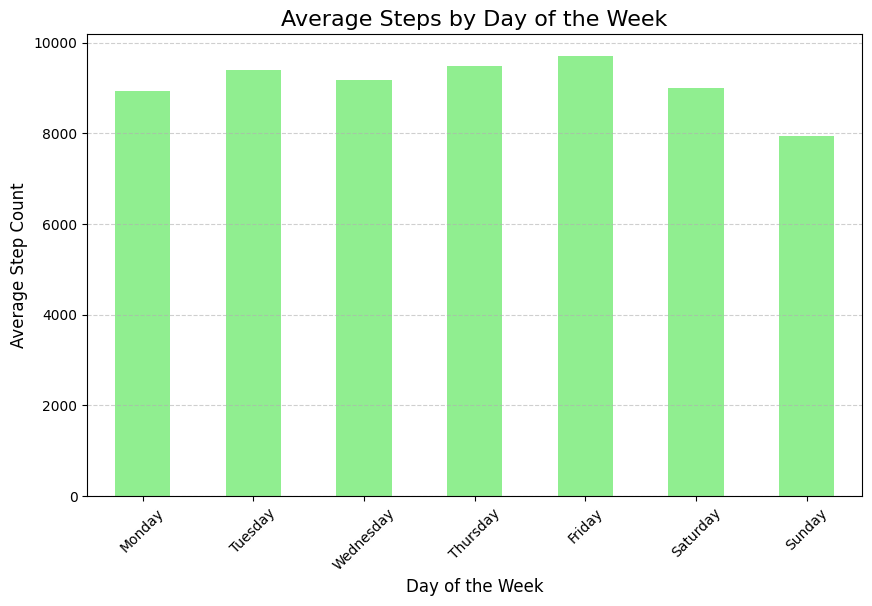

Average Steps by Day of the Week:
DayOfWeek
Monday       8928.134831
Tuesday      9388.904494
Wednesday    9181.505618
Thursday     9485.011236
Friday       9705.089888
Saturday     8996.157303
Sunday       7942.836158
Name: TotalSteps, dtype: float64


In [5]:
daily_steps["DayOfWeek"] = pd.to_datetime(daily_steps["Date"]).dt.day_name()

# Average step count by day of the week
weekly_steps = daily_steps.groupby("DayOfWeek")["TotalSteps"].mean().reindex([
    "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"
])

# Plot weekly trends
plt.figure(figsize=(10, 6))
weekly_steps.plot(kind="bar", color="lightgreen")
plt.title("Average Steps by Day of the Week", fontsize=16)
plt.xlabel("Day of the Week", fontsize=12)
plt.ylabel("Average Step Count", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

print("Average Steps by Day of the Week:")
print(weekly_steps)

In [6]:
max_steps = daily_steps.loc[daily_steps["TotalSteps"].idxmax()]
min_steps = daily_steps.loc[daily_steps["TotalSteps"].idxmin()]

print("Highest Activity Day:", max_steps)
print("Lowest Activity Day:", min_steps)

Highest Activity Day: Date              2022-04-22
TotalSteps           48972.0
ActivityLevel    Very Active
DayOfWeek             Friday
Name: 263, dtype: object
Lowest Activity Day: Date             2022-02-24
TotalSteps            146.0
ActivityLevel     Sedentary
DayOfWeek          Thursday
Name: 206, dtype: object


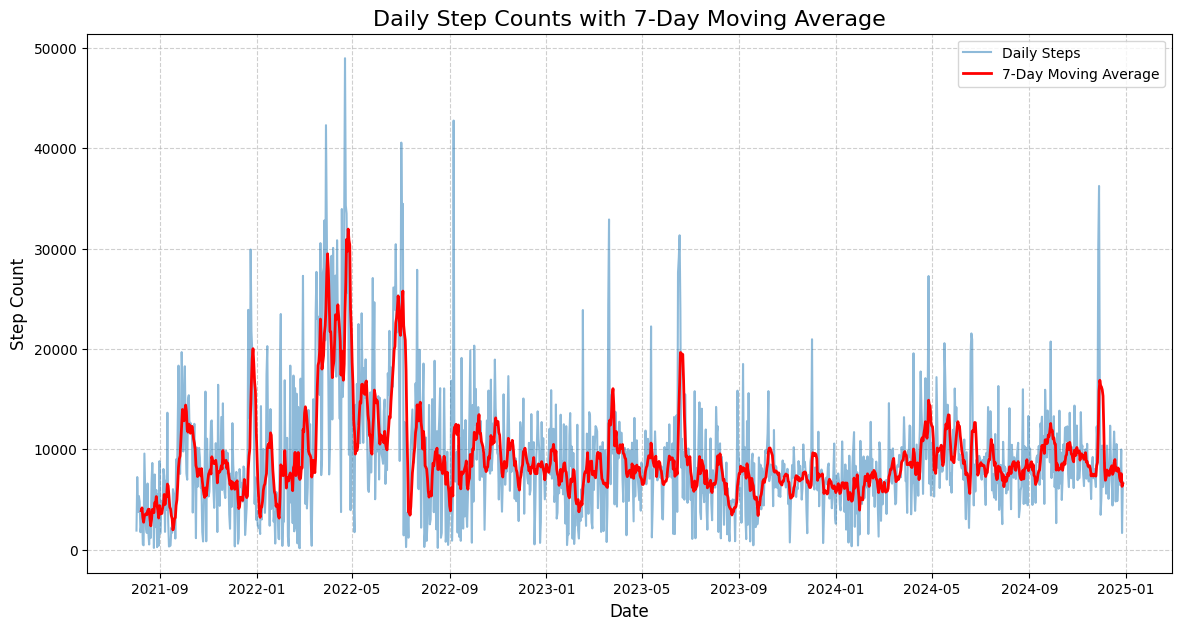

In [7]:
daily_steps["7DayAvg"] = daily_steps["TotalSteps"].rolling(window=7).mean()

# Plot daily steps with 7-day rolling average
plt.figure(figsize=(14, 7))
plt.plot(daily_steps["Date"], daily_steps["TotalSteps"], label="Daily Steps", alpha=0.5)
plt.plot(daily_steps["Date"], daily_steps["7DayAvg"], label="7-Day Moving Average", color="red", linewidth=2)
plt.title("Daily Step Counts with 7-Day Moving Average", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Step Count", fontsize=12)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

**CALORIE ANALYSIS**

/var/folders/s4/3xrjb_yx0l9d52y_sb4q175r0000gn/T/ipykernel_16809/4090675970.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_calories_after_may_2023["30DayRollingAvg"] = (


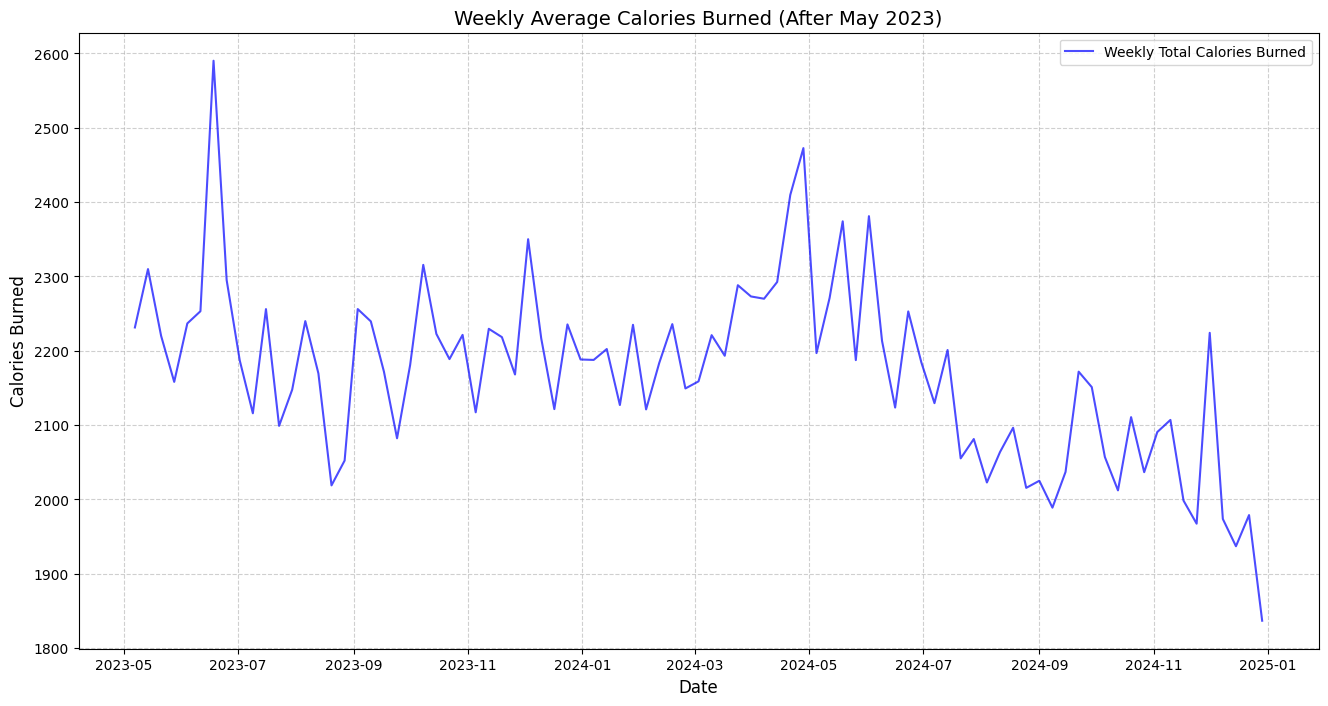

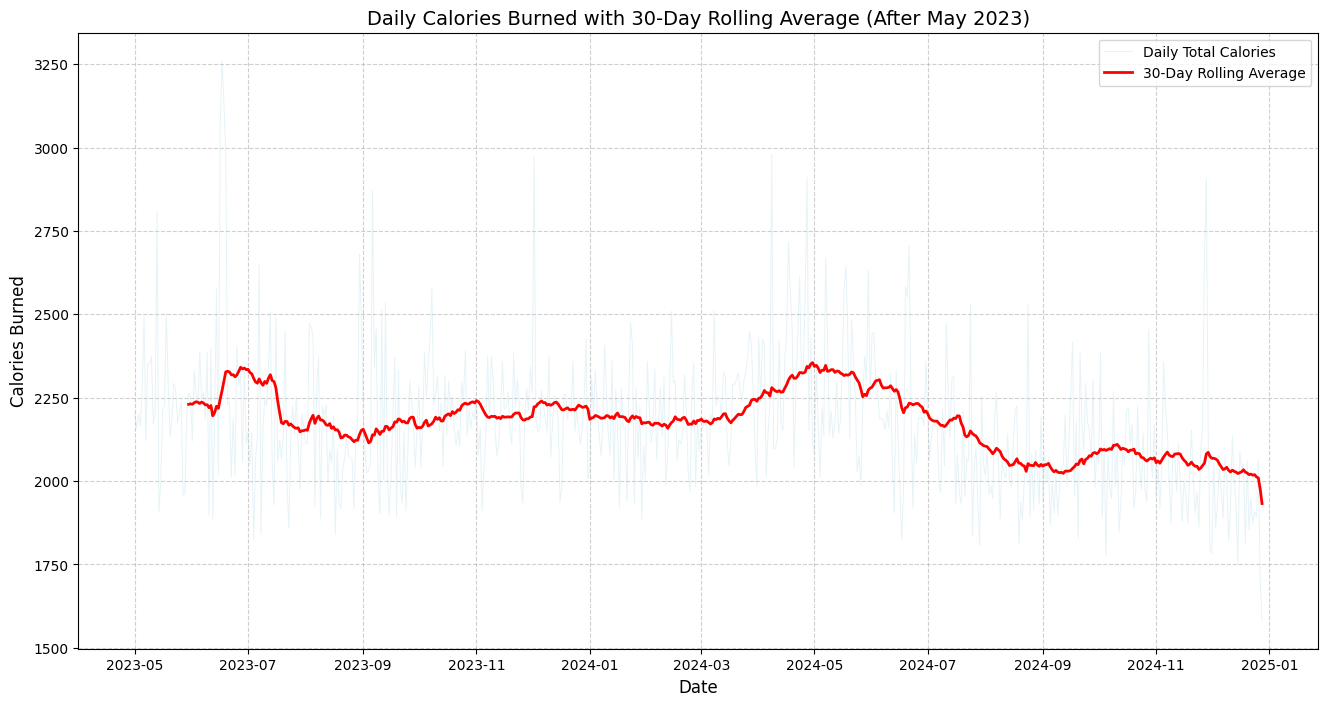

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Create filtered_calories DataFrame from daily_calories
daily_calories["Date"] = pd.to_datetime(daily_calories["Date"])
filtered_calories = daily_calories.set_index("Date")
filtered_calories["TotalCalories"] = filtered_calories["Active"] + filtered_calories["Basal"]

# Filter data from May 2023 onward
filtered_calories_after_may_2023 = filtered_calories[filtered_calories.index >= "2023-05-01"]

# Resample to weekly averages for the filtered data
weekly_calories_after_may_2023 = filtered_calories_after_may_2023.resample("W").mean().reset_index()

# Apply a 30-day rolling average to the filtered data
filtered_calories_after_may_2023["30DayRollingAvg"] = (
    filtered_calories_after_may_2023["TotalCalories"].rolling(window=30).mean()
)

# Plot 1: Weekly Averages After May 2023
plt.figure(figsize=(16, 8))
plt.plot(
    weekly_calories_after_may_2023["Date"],
    weekly_calories_after_may_2023["TotalCalories"],
    label="Weekly Total Calories Burned",
    color="blue",
    alpha=0.7,
)
plt.title("Weekly Average Calories Burned (After May 2023)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Calories Burned", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()

# Plot 2: Simplified Rolling Average After May 2023
plt.figure(figsize=(16, 8))

# Plot the daily data as a lighter line for context
plt.plot(
    filtered_calories_after_may_2023.index,
    filtered_calories_after_may_2023["TotalCalories"],
    label="Daily Total Calories",
    color="lightblue",
    alpha=0.3,
    linewidth=0.7
)

# Plot the 30-day rolling average
plt.plot(
    filtered_calories_after_may_2023.index,
    filtered_calories_after_may_2023["30DayRollingAvg"],
    label="30-Day Rolling Average",
    color="red",
    linewidth=2
)

plt.title("Daily Calories Burned with 30-Day Rolling Average (After May 2023)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Calories Burned", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()

/var/folders/s4/3xrjb_yx0l9d52y_sb4q175r0000gn/T/ipykernel_16809/3558294665.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_calories_after_may_2023["90DayRollingAvg"] = (


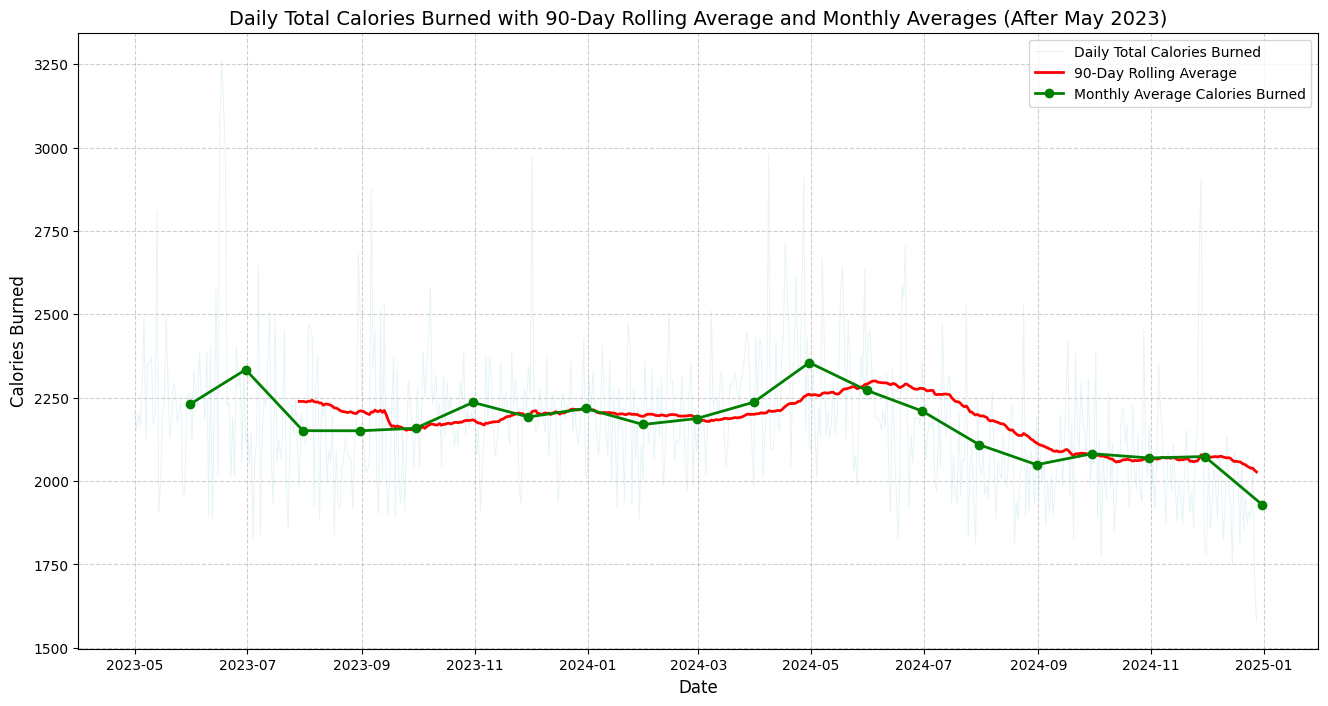

In [11]:
# Assuming `filtered_calories` DataFrame is already available and cleaned

# Filter data from May 2023 onward
filtered_calories_after_may_2023 = filtered_calories[filtered_calories.index >= "2023-05-01"]

# Resample to monthly averages for the filtered data
monthly_calories_after_may_2023 = filtered_calories_after_may_2023.resample("M").mean().reset_index()

# Apply a longer rolling average (e.g., 90-day rolling average)
filtered_calories_after_may_2023["90DayRollingAvg"] = (
    filtered_calories_after_may_2023["TotalCalories"].rolling(window=90).mean()
)

# Plot: Monthly Averages After May 2023 with 90-Day Rolling Average
plt.figure(figsize=(16, 8))

# Plot the daily data as a lighter line for context
plt.plot(
    filtered_calories_after_may_2023.index,
    filtered_calories_after_may_2023["TotalCalories"],
    label="Daily Total Calories Burned",
    color="lightblue",
    alpha=0.3,
    linewidth=0.7,
)

# Highlight the 90-day rolling average
plt.plot(
    filtered_calories_after_may_2023.index,
    filtered_calories_after_may_2023["90DayRollingAvg"],
    label="90-Day Rolling Average",
    color="red",
    linewidth=2,
)

# Highlight the monthly averages
plt.plot(
    monthly_calories_after_may_2023["Date"],
    monthly_calories_after_may_2023["TotalCalories"],
    label="Monthly Average Calories Burned",
    color="green",
    linewidth=2,
    marker='o'
)

plt.title("Daily Total Calories Burned with 90-Day Rolling Average and Monthly Averages (After May 2023)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Calories Burned", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()

/var/folders/s4/3xrjb_yx0l9d52y_sb4q175r0000gn/T/ipykernel_16809/298957001.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_calories_after_may_2023["Weekday"] = filtered_calories_after_may_2023.index.day_name()


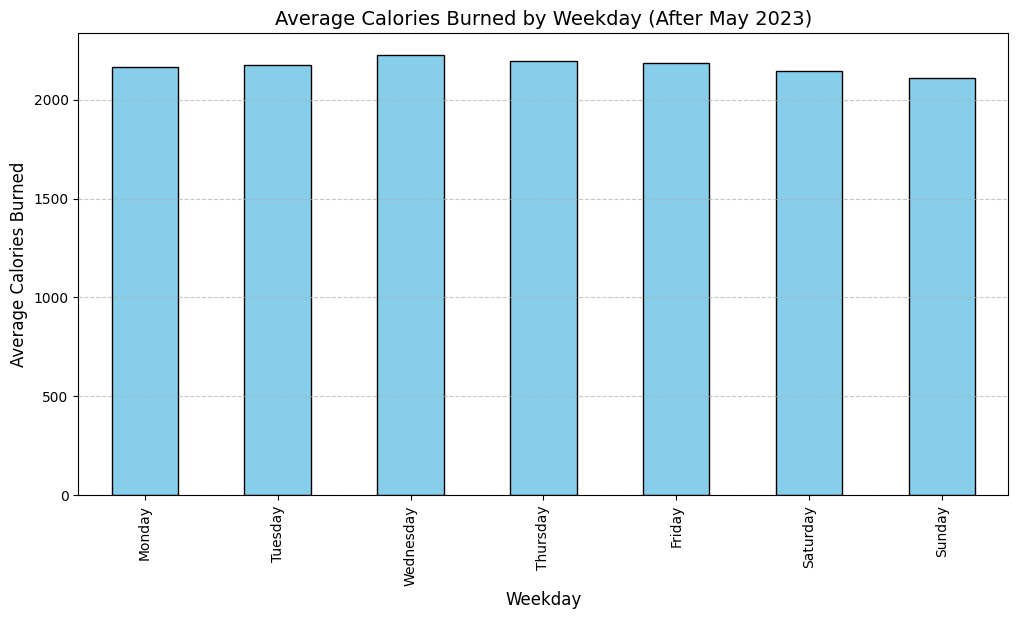

In [12]:
# Weekday Analysis
filtered_calories_after_may_2023["Weekday"] = filtered_calories_after_may_2023.index.day_name()
weekday_calories = (
    filtered_calories_after_may_2023.groupby("Weekday")["TotalCalories"]
    .mean()
    .reindex(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
)

# Plot: Weekday Analysis
plt.figure(figsize=(12, 6))
weekday_calories.plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Average Calories Burned by Weekday (After May 2023)", fontsize=14)
plt.xlabel("Weekday", fontsize=12)
plt.ylabel("Average Calories Burned", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()



/var/folders/s4/3xrjb_yx0l9d52y_sb4q175r0000gn/T/ipykernel_16809/4014582998.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_calories_after_may_2023["Season"] = filtered_calories_after_may_2023.index.map(get_season)


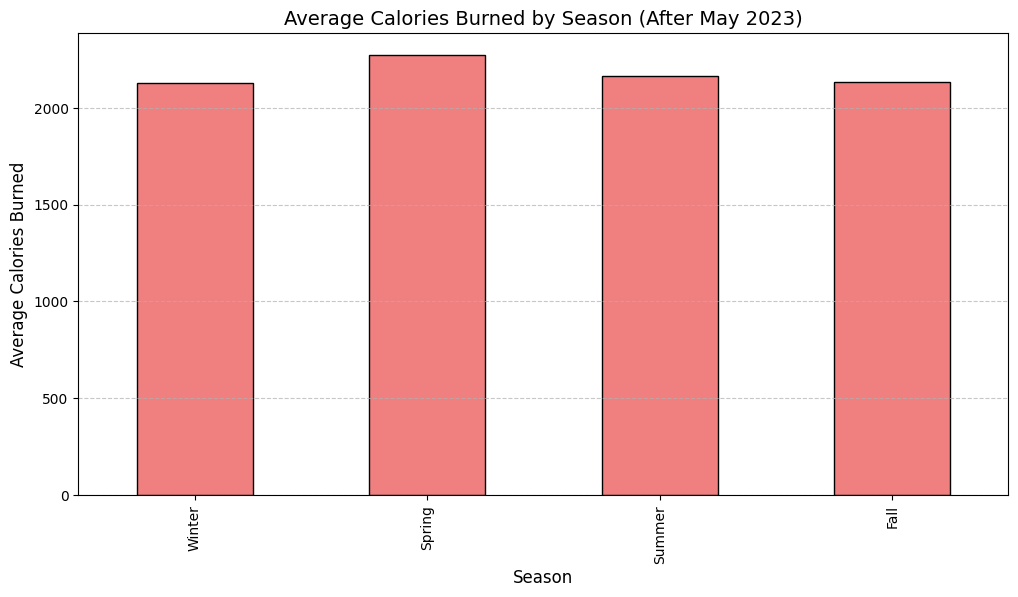

In [13]:
# Seasonal Analysis
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Fall"

filtered_calories_after_may_2023["Season"] = filtered_calories_after_may_2023.index.map(get_season)
seasonal_calories = (
    filtered_calories_after_may_2023.groupby("Season")["TotalCalories"]
    .mean()
    .reindex(["Winter", "Spring", "Summer", "Fall"])
)

# Plot: Seasonal Analysis
plt.figure(figsize=(12, 6))
seasonal_calories.plot(kind="bar", color="lightcoral", edgecolor="black")
plt.title("Average Calories Burned by Season (After May 2023)", fontsize=14)
plt.xlabel("Season", fontsize=12)
plt.ylabel("Average Calories Burned", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

**I have populated the data to have more detail in terms of the body mass**

In [14]:
# Assuming daily_body_mass is already defined
daily_body_mass["Date"] = pd.to_datetime(daily_body_mass["Date"])
daily_body_mass = daily_body_mass.sort_values(by="Date").reset_index(drop=True)

# Create a new DataFrame to store the interpolated data
interpolated_body_mass = pd.DataFrame(columns=["Date", "BodyMass"])

# Function to interpolate data
def interpolate_data(df):
    interpolated_df = pd.DataFrame(columns=["Date", "BodyMass"])
    for i in range(len(df) - 1):
        current_row = df.iloc[i]
        next_row = df.iloc[i + 1]
        
        # Calculate the midpoint date and average body mass
        midpoint_date = current_row["Date"] + (next_row["Date"] - current_row["Date"]) / 2
        average_body_mass = (current_row["BodyMass"] + next_row["BodyMass"]) / 2
        
        # Append the current row and the interpolated row to the new DataFrame
        interpolated_df = pd.concat([interpolated_df, pd.DataFrame([current_row])], ignore_index=True)
        interpolated_df = pd.concat([interpolated_df, pd.DataFrame([{"Date": midpoint_date, "BodyMass": average_body_mass}])], ignore_index=True)
    
    # Append the last row of the original DataFrame
    interpolated_df = pd.concat([interpolated_df, pd.DataFrame([df.iloc[-1]])], ignore_index=True)
    return interpolated_df

# Interpolate data four more times
for _ in range(4):
    daily_body_mass = interpolate_data(daily_body_mass)

# Display the interpolated DataFrame
print(daily_body_mass)

/var/folders/s4/3xrjb_yx0l9d52y_sb4q175r0000gn/T/ipykernel_16809/1882023878.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  interpolated_df = pd.concat([interpolated_df, pd.DataFrame([current_row])], ignore_index=True)
/var/folders/s4/3xrjb_yx0l9d52y_sb4q175r0000gn/T/ipykernel_16809/1882023878.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  interpolated_df = pd.concat([interpolated_df, pd.DataFrame([current_row])], ignore_index=True)
/var/folders/s4/3xrjb_yx0l9d52y_sb4q175r0000gn/T/ipy

                   Date  BodyMass
0   2021-09-22 00:00:00  77.50000
1   2021-09-27 12:00:00  77.65625
2   2021-10-03 00:00:00  77.81250
3   2021-10-08 12:00:00  77.96875
4   2021-10-14 00:00:00  78.12500
..                  ...       ...
732 2024-12-06 00:00:00  69.52500
733 2024-12-06 12:00:00  69.49375
734 2024-12-07 00:00:00  69.46250
735 2024-12-07 12:00:00  69.43125
736 2024-12-08 00:00:00  69.40000

[737 rows x 2 columns]


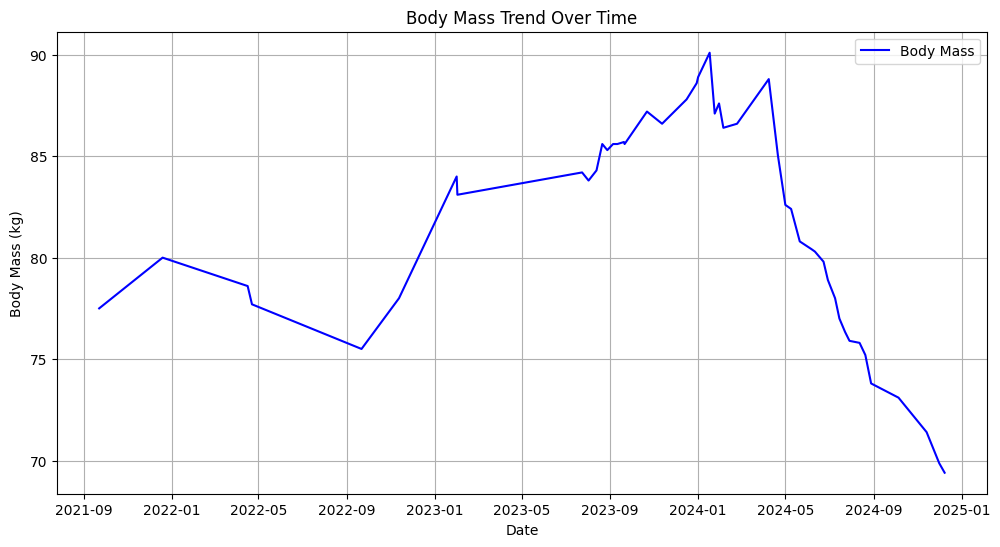

In [15]:
import matplotlib.pyplot as plt

# Set the Date column as the index for plotting
daily_body_mass["Date"] = pd.to_datetime(daily_body_mass["Date"])
daily_body_mass.set_index("Date", inplace=True)

# Plot the body mass trend
plt.figure(figsize=(12, 6))
plt.plot(daily_body_mass.index, daily_body_mass["BodyMass"], label="Body Mass", color="blue")
plt.title("Body Mass Trend Over Time")
plt.xlabel("Date")
plt.ylabel("Body Mass (kg)")
plt.grid()
plt.legend()
plt.show()

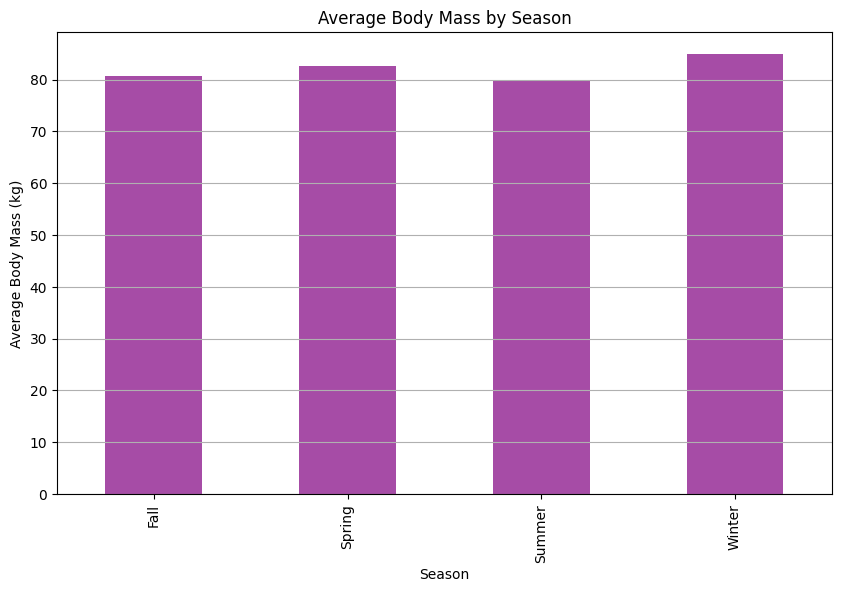

In [16]:
# Define seasons based on months
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

# Add a Season column
daily_body_mass['Season'] = daily_body_mass.index.map(get_season)

# Calculate average body mass for each season
seasonal_avg_body_mass = daily_body_mass.groupby('Season')['BodyMass'].mean()

# Plot seasonal averages
seasonal_avg_body_mass.plot(kind='bar', figsize=(10, 6), color='purple', alpha=0.7)
plt.title("Average Body Mass by Season")
plt.xlabel("Season")
plt.ylabel("Average Body Mass (kg)")
plt.grid(axis='y')
plt.show()

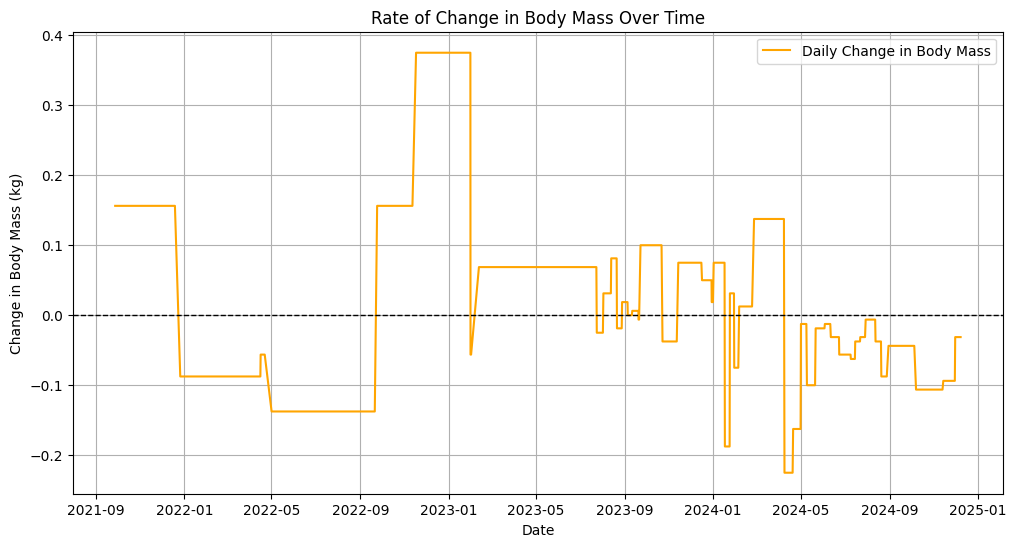

In [17]:
# Calculate daily changes in body mass
daily_body_mass['Change'] = daily_body_mass["BodyMass"].diff()

# Plot rate of change
plt.figure(figsize=(12, 6))
plt.plot(daily_body_mass.index, daily_body_mass["Change"], label="Daily Change in Body Mass", color="orange")
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title("Rate of Change in Body Mass Over Time")
plt.xlabel("Date")
plt.ylabel("Change in Body Mass (kg)")
plt.grid()
plt.legend()
plt.show()

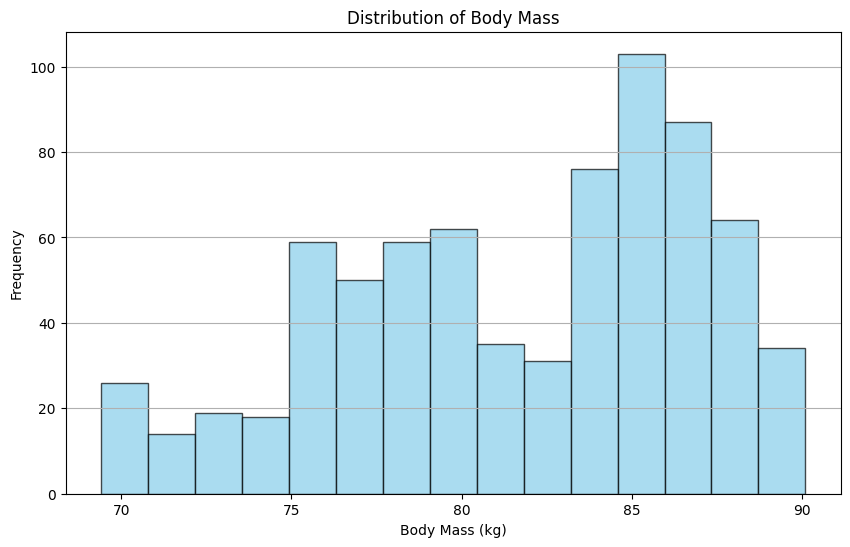

In [18]:
# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(daily_body_mass["BodyMass"], bins=15, color='skyblue', edgecolor='black', alpha=0.7)
plt.title("Distribution of Body Mass")
plt.xlabel("Body Mass (kg)")
plt.ylabel("Frequency")
plt.grid(axis='y')
plt.show()

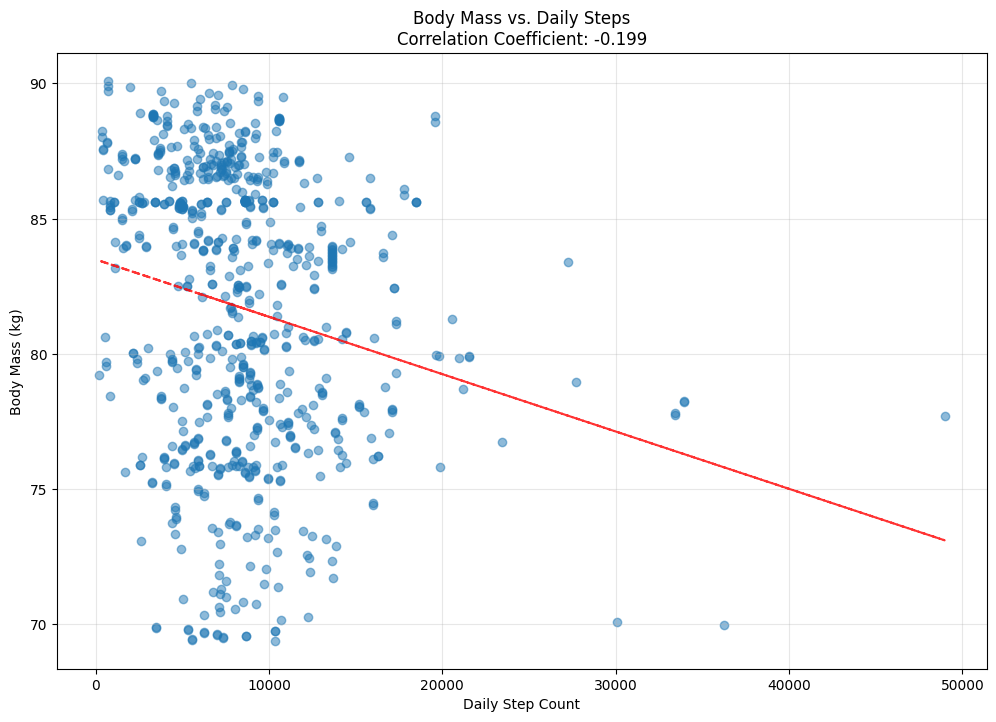


Correlation Analysis:
Number of matched data points: 737
Correlation coefficient: -0.199


In [27]:
import numpy as np

# First, ensure both datasets have compatible date formats
daily_body_mass.reset_index(inplace=True)
daily_body_mass['Date'] = pd.to_datetime(daily_body_mass['Date']).dt.date
daily_steps['Date'] = pd.to_datetime(daily_steps['Date']).dt.date

# Merge the datasets
correlation_df = pd.merge(daily_body_mass[['Date', 'BodyMass']], 
                         daily_steps[['Date', 'TotalSteps']], 
                         on='Date', 
                         how='inner')

# Calculate the correlation coefficient
correlation = correlation_df['BodyMass'].corr(correlation_df['TotalSteps'])

# Create a scatter plot
plt.figure(figsize=(12, 8))
plt.scatter(correlation_df['TotalSteps'], correlation_df['BodyMass'], alpha=0.5)
plt.xlabel('Daily Step Count')
plt.ylabel('Body Mass (kg)')
plt.title(f'Body Mass vs. Daily Steps\nCorrelation Coefficient: {correlation:.3f}')

# Add a trend line
z = np.polyfit(correlation_df['TotalSteps'], correlation_df['BodyMass'], 1)
p = np.poly1d(z)
plt.plot(correlation_df['TotalSteps'], p(correlation_df['TotalSteps']), "r--", alpha=0.8)

plt.grid(True, alpha=0.3)
plt.show()

# Print some basic statistics
print("\nCorrelation Analysis:")
print(f"Number of matched data points: {len(correlation_df)}")
print(f"Correlation coefficient: {correlation:.3f}")

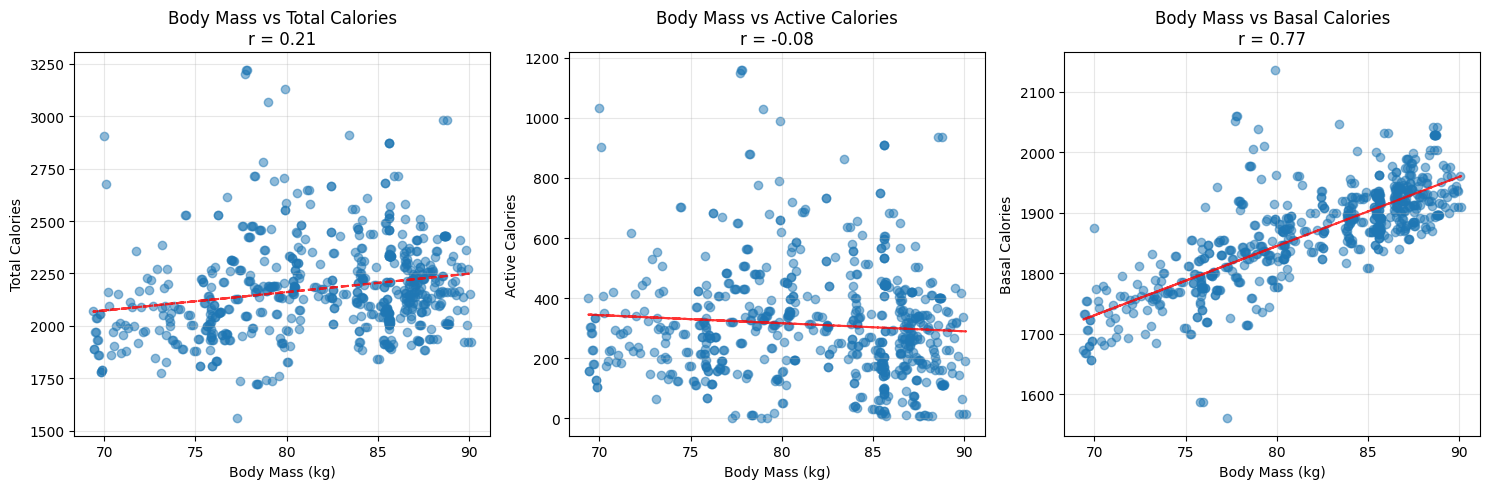


Correlation Analysis:
Total Calories: 0.210
Active Calories: -0.078
Basal Calories: 0.775

Summary Statistics:
         BodyMass  TotalCalories       Active        Basal
count  660.000000     660.000000   660.000000   660.000000
mean    81.887983    2177.958409   311.474179  1866.484230
std      5.441719     227.679935   188.871700    80.484673
min     69.400000    1559.925000     0.000000  1559.925000
25%     77.671875    2025.623000   179.267000  1820.910000
50%     83.853125    2153.109000   294.716500  1878.585000
75%     86.528125    2299.014000   408.737000  1920.094000
max     90.100000    3221.840000  1160.986000  2136.846000


In [32]:
# Prepare data for correlation analysis
# Reset index of filtered_calories and convert dates
filtered_calories_reset = filtered_calories.copy()
filtered_calories_reset = filtered_calories_reset.reset_index(drop=True)
filtered_calories_reset['Date'] = pd.to_datetime(filtered_calories_reset['Date']).dt.date
daily_body_mass['Date'] = pd.to_datetime(daily_body_mass['Date']).dt.date

# Merge body mass and calories data
body_mass_calories_corr = pd.merge(
    daily_body_mass[['Date', 'BodyMass']], 
    filtered_calories_reset[['Date', 'TotalCalories', 'Active', 'Basal']], 
    on='Date', 
    how='inner'
)

# Calculate correlations
correlations = {
    'Total Calories': body_mass_calories_corr['BodyMass'].corr(body_mass_calories_corr['TotalCalories']),
    'Active Calories': body_mass_calories_corr['BodyMass'].corr(body_mass_calories_corr['Active']),
    'Basal Calories': body_mass_calories_corr['BodyMass'].corr(body_mass_calories_corr['Basal'])
}

# Create scatter plot with regression lines
plt.figure(figsize=(15, 5))

# Total Calories vs Body Mass
plt.subplot(1, 3, 1)
plt.scatter(body_mass_calories_corr['BodyMass'], body_mass_calories_corr['TotalCalories'], alpha=0.5)
z = np.polyfit(body_mass_calories_corr['BodyMass'], body_mass_calories_corr['TotalCalories'], 1)
p = np.poly1d(z)
plt.plot(body_mass_calories_corr['BodyMass'], p(body_mass_calories_corr['BodyMass']), "r--", alpha=0.8)
plt.title(f'Body Mass vs Total Calories\nr = {correlations["Total Calories"]:.2f}')
plt.xlabel('Body Mass (kg)')
plt.ylabel('Total Calories')
plt.grid(True, alpha=0.3)

# Active Calories vs Body Mass
plt.subplot(1, 3, 2)
plt.scatter(body_mass_calories_corr['BodyMass'], body_mass_calories_corr['Active'], alpha=0.5)
z = np.polyfit(body_mass_calories_corr['BodyMass'], body_mass_calories_corr['Active'], 1)
p = np.poly1d(z)
plt.plot(body_mass_calories_corr['BodyMass'], p(body_mass_calories_corr['BodyMass']), "r--", alpha=0.8)
plt.title(f'Body Mass vs Active Calories\nr = {correlations["Active Calories"]:.2f}')
plt.xlabel('Body Mass (kg)')
plt.ylabel('Active Calories')
plt.grid(True, alpha=0.3)

# Basal Calories vs Body Mass
plt.subplot(1, 3, 3)
plt.scatter(body_mass_calories_corr['BodyMass'], body_mass_calories_corr['Basal'], alpha=0.5)
z = np.polyfit(body_mass_calories_corr['BodyMass'], body_mass_calories_corr['Basal'], 1)
p = np.poly1d(z)
plt.plot(body_mass_calories_corr['BodyMass'], p(body_mass_calories_corr['BodyMass']), "r--", alpha=0.8)
plt.title(f'Body Mass vs Basal Calories\nr = {correlations["Basal Calories"]:.2f}')
plt.xlabel('Body Mass (kg)')
plt.ylabel('Basal Calories')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print correlations and additional statistics
print("\nCorrelation Analysis:")
for key, value in correlations.items():
    print(f"{key}: {value:.3f}")

print("\nSummary Statistics:")
print(body_mass_calories_corr.describe())

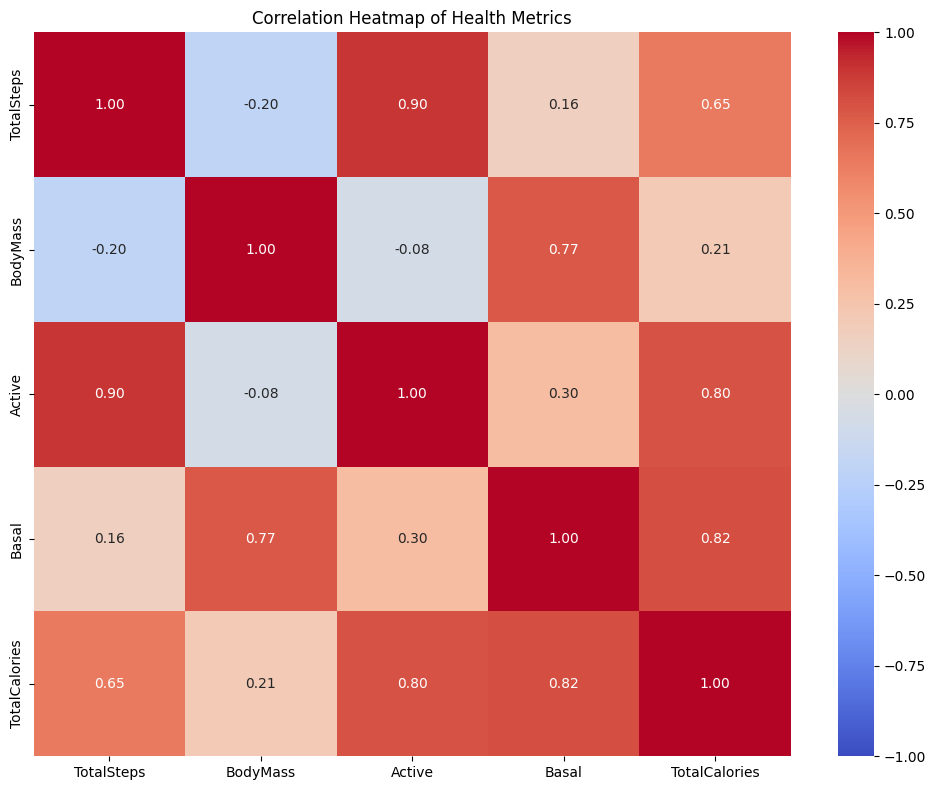

In [33]:
import seaborn as sns

# Create a correlation matrix from the combined data
correlation_matrix = pd.DataFrame()

# Prepare the data by merging relevant columns
merged_data = pd.merge(daily_steps[['Date', 'TotalSteps']], 
                      daily_body_mass[['Date', 'BodyMass']], 
                      on='Date', 
                      how='outer')
merged_data = pd.merge(merged_data, 
                      filtered_calories_reset[['Date', 'Active', 'Basal', 'TotalCalories']], 
                      on='Date', 
                      how='outer')

# Calculate correlation matrix
correlation_matrix = merged_data[['TotalSteps', 'BodyMass', 'Active', 'Basal', 'TotalCalories']].corr()

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, 
            annot=True, 
            cmap='coolwarm', 
            vmin=-1, 
            vmax=1, 
            center=0,
            fmt='.2f')
plt.title('Correlation Heatmap of Health Metrics')
plt.tight_layout()
plt.show()